<a href="https://colab.research.google.com/github/San-B19/SanjanaB/blob/main/Copy_of_starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [10]:
!pip install pyinputplus
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip


## 📦 Setup and Configuration
Import required packages and setup environment.

In [11]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
os.environ['OPENWEATHER_API_KEY'] = input("Enter your OpenWeatherMap API key: ")




Enter your OpenWeatherMap API key: 2572248d0b97e1fbe00601a93ce27e4c


## 🌤️ Weather Data Functions

In [17]:
 # Ensure all necessary packages are imported at the beginning of your notebook
# (Assuming the setup and imports cell has already been run)
# import os
# import requests
# import matplotlib.pyplot as plt
# import pyinputplus as pyip

# Define get_weather_data() function here
def get_weather_data(forecast_days=5):
    """
    Retrieves current and forecast weather data for Port Louis, Mauritius using OpenWeatherMap API.

    Parameters:
        forecast_days (int): Number of forecast days to retrieve (maximum 5).
                             OpenWeatherMap free tier provides 5 days of forecast data
                             in 3-hour intervals.

    Returns:
        dict: {
            'current': {'summary': str},
            'forecast': [
                {
                    'date': str,
                    'high': float,
                    'low': float,
                    'precipChance': int,
                    'summary': str
                },
                ...
            ]
        }
        or a dict with an 'error' key if something went wrong.
    """
    try:
        # 📍 Fixed location
        location = "Port Louis, Mauritius"

        # 🔐 Get API key from environment
        api_key = os.environ.get("OPENWEATHER_API_KEY")
        if not api_key:
            # Using pyip.inputStr to get API key for better handling if not set
            # Note: This will prompt every time the function is called if the key is not set.
            # A better approach might be to set it once at the start of the notebook.
             api_key = pyip.inputStr("Enter your OpenWeatherMap API key: ")
             os.environ['OPENWEATHER_API_KEY'] = api_key # Optionally set it for future calls

        # Basic validation for API key format (optional but good practice)
        if not isinstance(api_key, str) or len(api_key) == 0:
             raise ValueError("Invalid API key provided.")


        # 🌐 Prepare API request
        # Using the forecast endpoint which provides 5 days of 3-hour data
        url = (
            f"https://api.openweathermap.org/data/2.5/forecast"
            f"?q={location}&appid={api_key}&units=metric"
        )

        response = requests.get(url)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        if not data or not data.get("list"):
             return {"error": "❌ API returned no data or invalid format."}

        # 📊 Build forecast list - extracting one entry per day (the first one)
        forecast_data = []
        seen_dates = set()

        # The forecast data is in 3-hour intervals. We'll take the first entry
        # for each new day encountered up to the desired number of forecast_days.
        for entry in data.get("list", []):
            # Extract date string (YYYY-MM-DD)
            dt_txt = entry.get("dt_txt")
            if not dt_txt:
                continue # Skip entries without a datetime

            date = dt_txt.split(" ")[0]

            # Process this entry if it's a new day and we haven't reached forecast_days
            if date not in seen_dates and len(forecast_data) < forecast_days:
                seen_dates.add(date)

                # Extract required information, providing default values in case keys are missing
                temp_main = entry.get("main", {})
                weather_info = entry.get("weather", [{}])[0] # weather is a list, take the first element

                forecast_entry = {
                    "date": date,
                    # Note: temp_max and temp_min from the forecast endpoint at
                    # the 3-hour interval might not be the true daily max/min.
                    # This extracts the temp_max/min from the *first* entry of the day.
                    "high": round(temp_main.get("temp_max", 0.0), 1),
                    "low": round(temp_main.get("temp_min", 0.0), 1),
                    # 'pop' is probability of precipitation
                    "precipChance": round(entry.get("pop", 0.0) * 100),
                    "summary": weather_info.get("description", "N/A").capitalize()
                }
                forecast_data.append(forecast_entry)

            # Stop if we've collected enough days
            if len(forecast_data) >= forecast_days:
                break

        # 🌥️ Current condition - Use the weather description from the very first entry
        # as a proxy for the current condition.
        current = {
            "summary": data["list"][0].get("weather", [{}])[0].get("description", "N/A").capitalize()
        }

        return {
            "current": current,
            "forecast": forecast_data
        }

    except requests.exceptions.RequestException as e:
        # Catch specific requests exceptions for network/API call issues
        return {"error": f"❌ Network or API request error: {e}"}
    except ValueError as e:
         # Catch value errors, like missing API key
         return {"error": f"❌ Configuration error: {e}"}
    except KeyError as e:
        # Catch errors if expected keys are missing in the JSON response
        return {"error": f"❌ Data format error: Missing key {e}"}
    except Exception as e:
        # Catch any other unexpected errors
        return {"error": f"❌ An unexpected error occurred: {e}"}


# --- Code to call the function and display results ---

# Ensure the API key is set before calling the function
# You can set it once at the beginning of your notebook execution
# using the input method as before, or load it from a config file.
# Example:
# if 'OPENWEATHER_API_KEY' not in os.environ:
#     os.environ['OPENWEATHER_API_KEY'] = pyip.inputStr("Enter your OpenWeatherMap API key: ")

# Call the function
weather_data = get_weather_data(forecast_days=5) # Specify the number of forecast days

# Display the results
if "error" in weather_data:
    print(weather_data["error"])
else:
    print("📍 Current Weather in Port Louis:", weather_data.get("current", {}).get("summary", "N/A"))
    print(f"📅 {len(weather_data.get('forecast', []))}-Day Forecast:") # Print actual number of forecast days retrieved
    if weather_data.get("forecast"):
        for day in weather_data["forecast"]:
            print(f"  {day.get('date', 'N/A')} — 🌡️ {day.get('low', 'N/A')}°C to {day.get('high', 'N/A')}°C | ☔ {day.get('precipChance', 'N/A')}% | {day.get('summary', 'N/A')}")
    else:
        print("  No forecast data available.")


📍 Current Weather in Port Louis: Light rain
📅 5-Day Forecast:
  2025-05-14 — 🌡️ 26.3°C to 26.5°C | ☔ 48% | Light rain
  2025-05-15 — 🌡️ 25.1°C to 25.1°C | ☔ 100% | Light rain
  2025-05-16 — 🌡️ 24.6°C to 24.6°C | ☔ 4% | Scattered clouds
  2025-05-17 — 🌡️ 24.1°C to 24.1°C | ☔ 73% | Light rain
  2025-05-18 — 🌡️ 24.0°C to 24.0°C | ☔ 45% | Light rain


## 📊 Visualisation Functions

📍 Current Weather in Port Louis: Light rain
📅 5-Day Forecast:
  2025-05-14 — 🌡️ 26.3°C to 26.5°C | ☔ 48% | Light rain
  2025-05-15 — 🌡️ 25.1°C to 25.1°C | ☔ 100% | Light rain
  2025-05-16 — 🌡️ 24.6°C to 24.6°C | ☔ 4% | Scattered clouds
  2025-05-17 — 🌡️ 24.1°C to 24.1°C | ☔ 73% | Light rain
  2025-05-18 — 🌡️ 24.0°C to 24.0°C | ☔ 45% | Light rain

Creating visualisations...


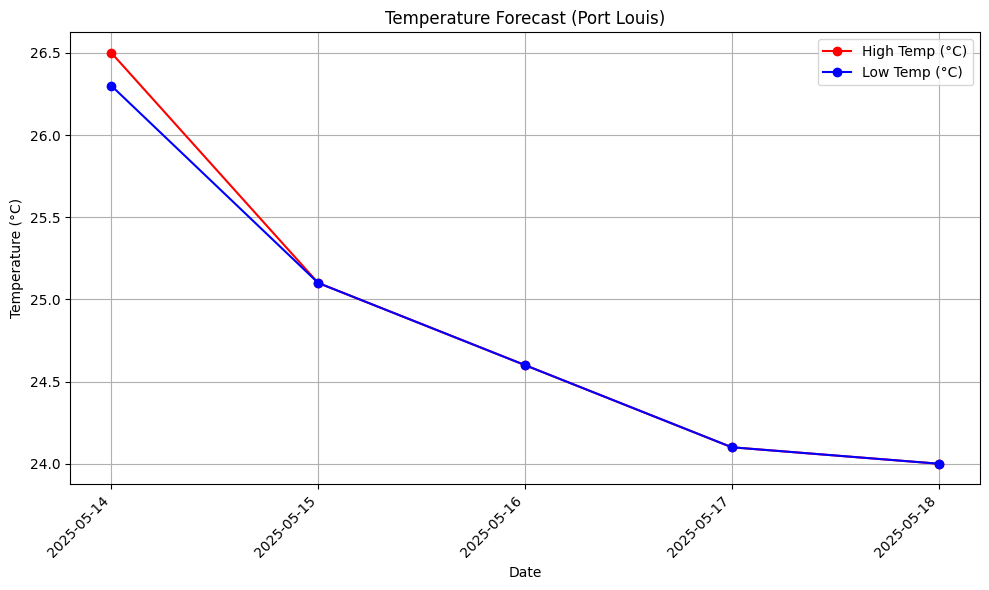

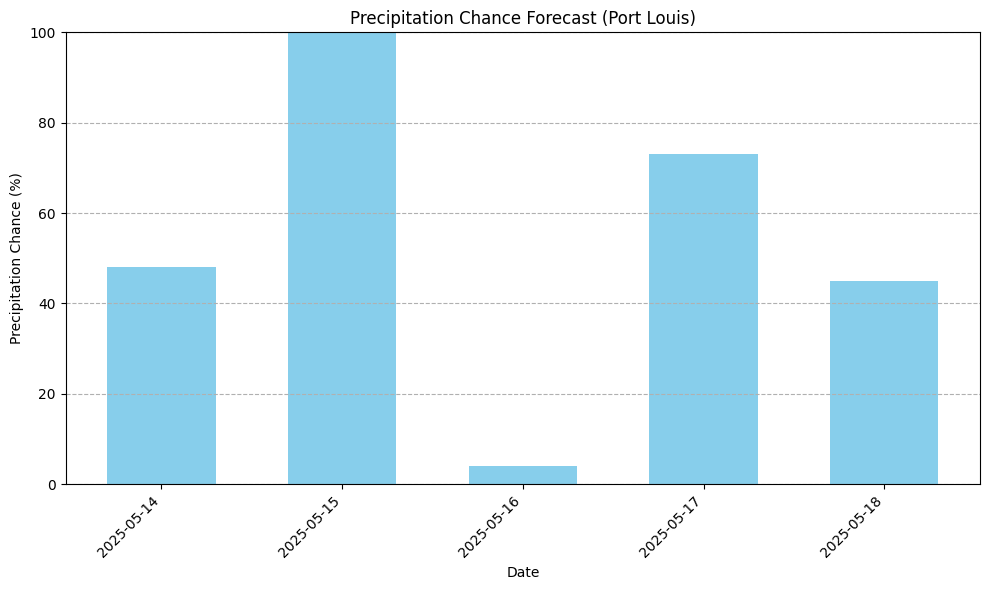

In [19]:
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import datetime # Needed for date handling in visualisations
import matplotlib.dates # Needed for date formatting on plot axis

# --- Setup and Configuration ---

# Get API key from environment, or prompt user if not set
api_key = os.environ.get("OPENWEATHER_API_KEY")
if not api_key:
    print("OpenWeatherMap API key not found in environment variables.")
    try:
        api_key = pyip.inputStr("Please enter your OpenWeatherMap API key: ")
        os.environ['OPENWEATHER_API_KEY'] = api_key # Set for this session
    except Exception as e:
        print(f"Failed to get API key input: {e}")
        api_key = None # Ensure api_key is None if input fails


# --- Weather Data Function ---

def get_weather_data(forecast_days=5):
    """
    Retrieves current and forecast weather data for Port Louis, Mauritius using OpenWeatherMap API.

    Parameters:
        forecast_days (int): Number of forecast days to retrieve (maximum 5 for free tier).

    Returns:
        dict: {
            'current': {'summary': str},
            'forecast': [
                {
                    'date': str,
                    'high': float,
                    'low': float,
                    'precipChance': int,
                    'summary': str
                },
                ...
            ]
        }
        or a dict with an 'error' key if something went wrong.
    """
    # Get API key from environment (set previously or via input)
    api_key = os.environ.get("OPENWEATHER_API_KEY")

    if not api_key:
        return {"error": "❌ Configuration error: OpenWeatherMap API key is not set."}

    try:
        # 📍 Fixed location
        location = "Port Louis, Mauritius"

        # 🌐 Prepare API request
        # Using the forecast endpoint which provides 5 days of 3-hour data
        url = (
            f"https://api.openweathermap.org/data/2.5/forecast"
            f"?q={location}&appid={api_key}&units=metric"
        )

        response = requests.get(url)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        if not data or not data.get("list"):
             return {"error": "❌ API returned no data or invalid format."}

        # 📊 Build forecast list - extracting one entry per day (the first one)
        forecast_data = []
        seen_dates = set()

        # The forecast data is in 3-hour intervals. We'll take the first entry
        # for each new day encountered up to the desired number of forecast_days.
        for entry in data.get("list", []):
            # Extract date string (YYYY-MM-DD)
            dt_txt = entry.get("dt_txt")
            if not dt_txt:
                continue # Skip entries without a datetime

            date = dt_txt.split(" ")[0]

            # Process this entry if it's a new day and we haven't reached forecast_days
            if date not in seen_dates and len(forecast_data) < forecast_days:
                seen_dates.add(date)

                # Extract required information, providing default values in case keys are missing
                temp_main = entry.get("main", {})
                weather_info = entry.get("weather", [{}])[0] # weather is a list, take the first element

                forecast_entry = {
                    "date": date,
                    # Note: temp_max and temp_min from the forecast endpoint at
                    # the 3-hour interval might not be the true daily max/min.
                    # This extracts the temp_max/min from the *first* entry of the day.
                    "high": round(temp_main.get("temp_max", 0.0), 1),
                    "low": round(temp_main.get("temp_min", 0.0), 1),
                    # 'pop' is probability of precipitation
                    "precipChance": round(entry.get("pop", 0.0) * 100),
                    "summary": weather_info.get("description", "N/A").capitalize()
                }
                forecast_data.append(forecast_entry)

            # Stop if we've collected enough days
            if len(forecast_data) >= forecast_days:
                break

        # 🌥️ Current condition - Use the weather description from the very first entry
        # as a proxy for the current condition.
        # Use .get() for safety
        current_summary = data.get("list", [{}])[0].get("weather", [{}])[0].get("description", "N/A").capitalize()
        current = {"summary": current_summary}


        return {
            "current": current,
            "forecast": forecast_data
        }

    except requests.exceptions.RequestException as e:
        # Catch specific requests exceptions for network/API call issues
        return {"error": f"❌ Network or API request error: {e}"}
    except ValueError as e:
         # Catch value errors, like issues with data processing
         return {"error": f"❌ Data processing error: {e}"}
    except KeyError as e:
        # Catch errors if expected keys are missing in the JSON response
        return {"error": f"❌ Data format error: Missing key {e}"}
    except Exception as e:
        # Catch any other unexpected errors
        return {"error": f"❌ An unexpected error occurred: {e}"}


# --- Visualisation Functions ---

def create_temperature_visualisation(weather_data):
    """
    Creates and displays a temperature forecast visualisation (High and Low).

    Parameters:
        weather_data (dict): The dictionary returned by get_weather_data().
                             Expected format: {'forecast': [{'date': str, 'high': float, 'low': float, ...}, ...]}

    Returns:
        None. Displays a matplotlib plot.
    """
    if "error" in weather_data or not weather_data.get("forecast"):
        print("Cannot create temperature visualisation: No valid forecast data.")
        return

    forecast = weather_data["forecast"]

    # Extract data for plotting, ensuring defaults
    dates = [day.get("date", "N/A") for day in forecast]
    highs = [day.get("high", 0.0) for day in forecast]
    lows = [day.get("low", 0.0) for day in forecast]

    # Convert date strings to datetime objects for better plotting on the x-axis
    plot_dates = []
    plot_highs = []
    plot_lows = []
    for i, d in enumerate(dates):
        if d != 'N/A':
            try:
                plot_dates.append(datetime.datetime.strptime(d, "%Y-%m-%d"))
                plot_highs.append(highs[i])
                plot_lows.append(lows[i])
            except ValueError:
                print(f"Warning: Could not parse date '{d}'. Skipping entry for visualisation.")
                continue # Skip this date if parsing fails


    if not plot_dates:
        print("No valid dates found in forecast data for visualisation.")
        return

    # Create the plot
    plt.figure(figsize=(10, 6)) # Set the figure size

    # Plot high temperatures
    plt.plot(plot_dates, plot_highs, marker='o', linestyle='-', color='red', label='High Temp (°C)')

    # Plot low temperatures
    plt.plot(plot_dates, plot_lows, marker='o', linestyle='-', color='blue', label='Low Temp (°C)')

    # Add titles and labels
    plt.title("Temperature Forecast (Port Louis)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)

    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator())
    plt.xticks(rotation=45, ha='right') # Rotate dates for better readability

    plt.tight_layout() # Adjust layout to prevent labels overlapping

    # Show the plot
    plt.show()


def create_precipitation_visualisation(weather_data):
    """
    Creates and displays a precipitation chance forecast visualisation.

    Parameters:
        weather_data (dict): The dictionary returned by get_weather_data().
                             Expected format: {'forecast': [{'date': str, 'precipChance': int, ...}, ...]}

    Returns:
        None. Displays a matplotlib plot.
    """
    if "error" in weather_data or not weather_data.get("forecast"):
        print("Cannot create precipitation visualisation: No valid forecast data.")
        return

    forecast = weather_data["forecast"]

    # Extract data for plotting, ensuring defaults
    dates = [day.get("date", "N/A") for day in forecast]
    precip_chances = [day.get("precipChance", 0) for day in forecast]

    # Convert date strings to datetime objects for better plotting on the x-axis
    plot_dates = []
    plot_precip_chances = []
    for i, d in enumerate(dates):
         if d != 'N/A':
            try:
                plot_dates.append(datetime.datetime.strptime(d, "%Y-%m-%d"))
                plot_precip_chances.append(precip_chances[i])
            except ValueError:
                print(f"Warning: Could not parse date '{d}'. Skipping entry for visualisation.")
                continue # Skip this date if parsing fails


    if not plot_dates:
        print("No valid dates found in forecast data for visualisation.")
        return

    # Create the plot
    plt.figure(figsize=(10, 6)) # Set the figure size

    # Create a bar chart for precipitation chance
    # We need positions for the bars and labels
    x_positions = range(len(plot_dates))
    # Use plot_dates directly with bar for better date handling on x-axis
    plt.bar(plot_dates, plot_precip_chances, color='skyblue', width=0.6) # Add width for bar spacing

    # Add titles and labels
    plt.title("Precipitation Chance Forecast (Port Louis)")
    plt.xlabel("Date")
    plt.ylabel("Precipitation Chance (%)")
    plt.ylim(0, 100) # Precipitation chance is between 0 and 100
    plt.grid(axis='y', linestyle='--') # Add horizontal grid lines

    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator())
    plt.xticks(rotation=45, ha='right') # Rotate dates for better readability

    plt.tight_layout() # Adjust layout

    # Show the plot
    plt.show()


# --- Main Application Logic (Example Usage) ---

# Call the function to get weather data
weather_data = get_weather_data(forecast_days=5) # Specify the number of forecast days

# Display the results
if "error" in weather_data:
    print(weather_data["error"])
else:
    print("📍 Current Weather in Port Louis:", weather_data.get("current", {}).get("summary", "N/A"))
    # Safely get forecast length
    forecast_length = len(weather_data.get('forecast', []))
    print(f"📅 {forecast_length}-Day Forecast:")
    if weather_data.get("forecast"):
        for day in weather_data["forecast"]:
            print(f"  {day.get('date', 'N/A')} — 🌡️ {day.get('low', 'N/A')}°C to {day.get('high', 'N/A')}°C | ☔ {day.get('precipChance', 'N/A')}% | {day.get('summary', 'N/A')}")
    else:
        print("  No forecast data available.")

    # Create and display visualisations if data is available
    print("\nCreating visualisations...")
    create_temperature_visualisation(weather_data)
    create_precipitation_visualisation(weather_data)

## 🤖 Natural Language Processing

--- Running WeatherWise Core Functionality ---

--- Weather Data ---
📍 Current Weather in Port Louis: Light rain
📅 5-Day Forecast:
  2025-05-14 — 🌡️ 25.8°C to 26.5°C | ☔ 48% | Light rain
  2025-05-15 — 🌡️ 25.1°C to 25.1°C | ☔ 100% | Light rain
  2025-05-16 — 🌡️ 24.6°C to 24.6°C | ☔ 4% | Scattered clouds
  2025-05-17 — 🌡️ 24.1°C to 24.1°C | ☔ 73% | Light rain
  2025-05-18 — 🌡️ 24.0°C to 24.0°C | ☔ 45% | Light rain

--- Visualisations ---


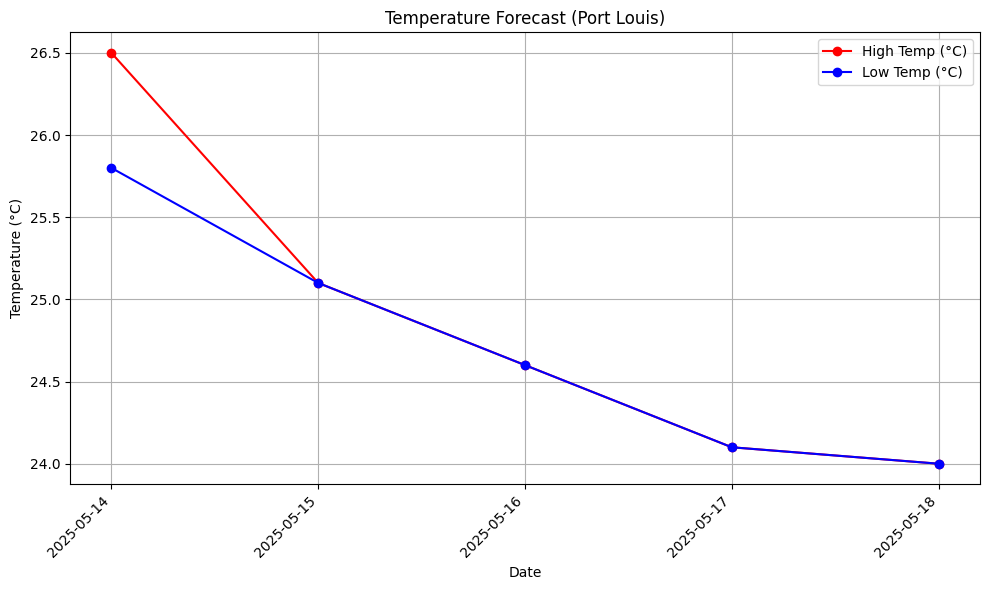

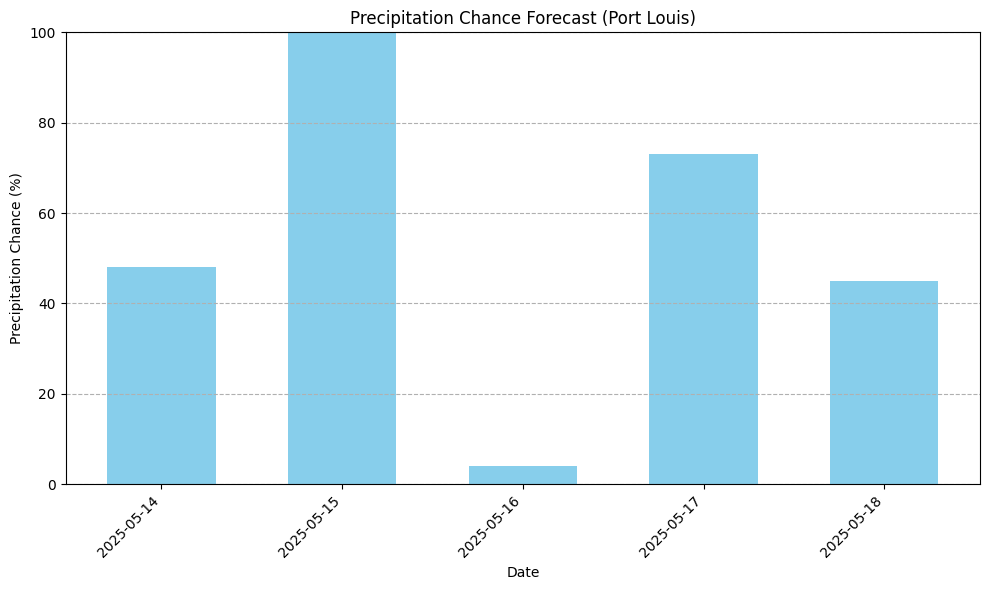


--- NLP Demonstration ---

User: What is the weather like today?
WeatherWise: Currently, the weather is Light rain. Today's forecast (2025-05-14): Light rain, with a high of 26.5°C and a low of 25.8°C. There's a 48% chance of precipitation.

User: Tell me about the temperature tomorrow
WeatherWise: Tomorrow (2025-05-15), the temperature will range from 25.1°C to 25.1°C.

User: Is there any rain expected today?
WeatherWise: Currently, the weather is Light rain. Today (2025-05-14), there is a 48% chance of precipitation.

User: What about precipitation tomorrow?
WeatherWise: Tomorrow (2025-05-15), there is a 100% chance of precipitation.

User: How hot will it be today?
WeatherWise: Currently, the weather is Light rain. Today's forecast (2025-05-14): Light rain, with a high of 26.5°C and a low of 25.8°C. There's a 48% chance of precipitation.

--- End of Execution ---


In [28]:
## 🌦️ WeatherWise – Complete Code Block

# --- Setup and Imports ---
# Install necessary packages (only needs to be run once if not already installed)
# You might need to run this line separately in a cell above if running the whole block causes issues.
# !pip install pyinputplus requests matplotlib

# Import necessary libraries
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import datetime # Needed for date handling in visualisations
import matplotlib.dates # Needed for date formatting on plot axis
from IPython.display import display # Used in notebooks to display plots correctly

# --- Configuration ---
# Get API key from environment, or prompt user if not set
api_key = os.environ.get("OPENWEATHER_API_KEY")
if not api_key:
    print("OpenWeatherMap API key not found in environment variables.")
    try:
        # pyip.inputStr provides better input handling
        api_key = pyip.inputStr("Please enter your OpenWeatherMap API key: ")
        os.environ['OPENWEATHER_API_KEY'] = api_key # Set for this session
    except Exception as e:
        print(f"Failed to get API key input: {e}")
        # If key input fails, the get_weather_data function will handle the missing key
        api_key = None # Ensure api_key is None if input fails

# --- Weather Data Function ---
def get_weather_data(forecast_days=5):
    """
    Retrieves current and forecast weather data for Port Louis, Mauritius using OpenWeatherMap API.

    Parameters:
        forecast_days (int): Number of forecast days to retrieve (maximum 5 for free tier).

    Returns:
        dict: {
            'current': {'summary': str},
            'forecast': [
                {
                    'date': str,
                    'high': float,
                    'low': float,
                    'precipChance': int,
                    'summary': str
                },
                ...
            ]
        }
        or a dict with an 'error' key if something went wrong.
    """
    # Get API key from environment (set previously or via input)
    api_key = os.environ.get("OPENWEATHER_API_KEY")

    if not api_key:
        # Return a specific error if API key is not available at this point
        return {"error": "❌ Configuration error: OpenWeatherMap API key is not set."}

    try:
        # 📍 Fixed location
        location = "Port Louis, Mauritius"

        # 🌐 Prepare API request
        # Using the forecast endpoint which provides 5 days of 3-hour data
        url = (
            f"https://api.openweathermap.org/data/2.5/forecast"
            f"?q={location}&appid={api_key}&units=metric"
        )

        response = requests.get(url)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        if not data or not data.get("list"):
             return {"error": "❌ API returned no data or invalid format."}

        # 📊 Build forecast list - extracting one entry per day (the first one)
        forecast_data = []
        seen_dates = set()

        # The forecast data is in 3-hour intervals. We'll take the first entry
        # for each new day encountered up to the desired number of forecast_days.
        for entry in data.get("list", []):
            # Extract date string (YYYY-MM-DD)
            dt_txt = entry.get("dt_txt")
            if not dt_txt:
                continue # Skip entries without a datetime

            date = dt_txt.split(" ")[0]

            # Process this entry if it's a new day and we haven't reached forecast_days
            if date not in seen_dates and len(forecast_data) < forecast_days:
                seen_dates.add(date)

                # Extract required information, providing default values in case keys are missing
                temp_main = entry.get("main", {})
                weather_info = entry.get("weather", [{}])[0] # weather is a list, take the first element

                forecast_entry = {
                    "date": date,
                    # Note: temp_max and temp_min from the forecast endpoint at
                    # the 3-hour interval might not be the true daily max/min.
                    # This extracts the temp_max/min from the *first* entry of the day.
                    "high": round(temp_main.get("temp_max", 0.0), 1),
                    "low": round(temp_main.get("temp_min", 0.0), 1),
                    # 'pop' is probability of precipitation
                    "precipChance": round(entry.get("pop", 0.0) * 100),
                    "summary": weather_info.get("description", "N/A").capitalize()
                }
                forecast_data.append(forecast_entry)

            # Stop if we've collected enough days
            if len(forecast_data) >= forecast_days:
                break

        # 🌥️ Current condition - Use the weather description from the very first entry
        # as a proxy for the current condition.
        # Use .get() for safety
        current_summary = data.get("list", [{}])[0].get("weather", [{}])[0].get("description", "N/A").capitalize()
        current = {"summary": current_summary}


        return {
            "current": current,
            "forecast": forecast_data
        }

    except requests.exceptions.RequestException as e:
        # Catch specific requests exceptions for network/API call issues
        return {"error": f"❌ Network or API request error: {e}"}
    except ValueError as e:
         # Catch value errors, like issues with data processing
         return {"error": f"❌ Data processing error: {e}"}
    except KeyError as e:
        # Catch errors if expected keys are missing in the JSON response
        return {"error": f"❌ Data format error: Missing key {e}"}
    except Exception as e:
        # Catch any other unexpected errors
        return {"error": f"❌ An unexpected error occurred: {e}"}


# --- Visualisation Functions ---

def create_temperature_visualisation(weather_data):
    """
    Creates and displays a temperature forecast visualisation (High and Low).

    Parameters:
        weather_data (dict): The dictionary returned by get_weather_data().
                             Expected format: {'forecast': [{'date': str, 'high': float, 'low': float, ...}, ...]}

    Returns:
        None. Displays a matplotlib plot.
    """
    if "error" in weather_data or not weather_data.get("forecast"):
        print("Cannot create temperature visualisation: No valid forecast data.")
        return

    forecast = weather_data["forecast"]

    # Extract data for plotting, ensuring defaults
    dates = [day.get("date", "N/A") for day in forecast]
    highs = [day.get("high", 0.0) for day in forecast]
    lows = [day.get("low", 0.0) for day in forecast]

    # Convert date strings to datetime objects for better plotting on the x-axis
    plot_dates = []
    plot_highs = []
    plot_lows = []
    for i, d in enumerate(dates):
        if d != 'N/A':
            try:
                plot_dates.append(datetime.datetime.strptime(d, "%Y-%m-%d"))
                plot_highs.append(highs[i])
                plot_lows.append(lows[i])
            except ValueError:
                print(f"Warning: Could not parse date '{d}'. Skipping entry for visualisation.")
                continue # Skip this date if parsing fails


    if not plot_dates:
        print("No valid dates found in forecast data for visualisation.")
        return

    # Create the plot
    plt.figure(figsize=(10, 6)) # Set the figure size

    # Plot high temperatures
    plt.plot(plot_dates, plot_highs, marker='o', linestyle='-', color='red', label='High Temp (°C)')

    # Plot low temperatures
    plt.plot(plot_dates, plot_lows, marker='o', linestyle='-', color='blue', label='Low Temp (°C)')

    # Add titles and labels
    plt.title("Temperature Forecast (Port Louis)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)

    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator())
    plt.xticks(rotation=45, ha='right') # Rotate dates for better readability

    plt.tight_layout() # Adjust layout to prevent labels overlapping

    # Show the plot
    plt.show()


def create_precipitation_visualisation(weather_data):
    """
    Creates and displays a precipitation chance forecast visualisation.

    Parameters:
        weather_data (dict): The dictionary returned by get_weather_data().
                             Expected format: {'forecast': [{'date': str, 'precipChance': int, ...}, ...]}

    Returns:
        None. Displays a matplotlib plot.
    """
    if "error" in weather_data or not weather_data.get("forecast"):
        print("Cannot create precipitation visualisation: No valid forecast data.")
        return

    forecast = weather_data["forecast"]

    # Extract data for plotting, ensuring defaults
    dates = [day.get("date", "N/A") for day in forecast]
    precip_chances = [day.get("precipChance", 0) for day in forecast]

    # Convert date strings to datetime objects for better plotting on the x-axis
    plot_dates = []
    plot_precip_chances = []
    for i, d in enumerate(dates):
         if d != 'N/A':
            try:
                plot_dates.append(datetime.datetime.strptime(d, "%Y-%m-%d"))
                plot_precip_chances.append(precip_chances[i])
            except ValueError:
                print(f"Warning: Could not parse date '{d}'. Skipping entry for visualisation.")
                continue # Skip this date if parsing fails


    if not plot_dates:
        print("No valid dates found in forecast data for visualisation.")
        return

    # Create the plot
    plt.figure(figsize=(10, 6)) # Set the figure size

    # Create a bar chart for precipitation chance
    # Use plot_dates directly with bar for better date handling on x-axis
    plt.bar(plot_dates, plot_precip_chances, color='skyblue', width=0.6) # Add width for bar spacing

    # Add titles and labels
    plt.title("Precipitation Chance Forecast (Port Louis)")
    plt.xlabel("Date")
    plt.ylabel("Precipitation Chance (%)")
    plt.ylim(0, 100) # Precipitation chance is between 0 and 100
    plt.grid(axis='y', linestyle='--') # Add horizontal grid lines

    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator())
    plt.xticks(rotation=45, ha='right') # Rotate dates for better readability

    plt.tight_layout() # Adjust layout

    # Show the plot
    plt.show()

# --- Natural Language Processing Functions ---

def parse_weather_question(question):
    """
    Parses a user's natural language weather question to extract relevant information.

    Parameters:
        question (str): The user's weather question.

    Returns:
        dict: A dictionary containing parsed information like the requested date(s)
              and type of weather information (e.g., 'summary', 'temperature', 'precipitation').
              Returns default values or indicators if information cannot be extracted.
    """
    # Convert to lowercase for easier processing
    question = question.lower()

    # Initialize a dictionary to store parsed information
    parsed_info = {
        'date': 'today',  # Default to today if no specific date is mentioned
        'info_type': 'summary' # Default to summary
    }

    # Simple keyword matching for date
    if 'tomorrow' in question:
        parsed_info['date'] = 'tomorrow'
    elif 'weekend' in question:
        parsed_info['date'] = 'weekend' # This would need more complex date logic later
    elif 'today' in question:
        parsed_info['date'] = 'today'
    # You could add more complex date parsing here using libraries or regex

    # Simple keyword matching for info type
    if 'temperature' in question or 'temp' in question:
        parsed_info['info_type'] = 'temperature'
    elif 'rain' in question or 'precipitation' in question:
        parsed_info['info_type'] = 'precipitation'
    elif 'summary' in question or 'weather like' in question:
        parsed_info['info_type'] = 'summary'

    return parsed_info

def generate_weather_response(parsed_info, weather_data):
    """
    Generates a natural language response based on parsed user input and weather data.

    Parameters:
        parsed_info (dict): Dictionary from parse_weather_question().
        weather_data (dict): The dictionary returned by get_weather_data().

    Returns:
        str: A natural language response about the weather.
    """
    if "error" in weather_data:
        return f"Sorry, I could not retrieve weather data: {weather_data['error']}"

    forecast = weather_data.get('forecast', [])
    current = weather_data.get('current', {})

    requested_date_str = parsed_info.get('date', 'today')
    info_type = parsed_info.get('info_type', 'summary')

    # Simple date logic based on 'today' and 'tomorrow'
    # target_date variable is not used in the current logic
    # target_date = None

    if requested_date_str == 'today':
        # For 'today', we'll use the current summary and the first day of the forecast
        response_parts = []
        if current.get('summary'):
            response_parts.append(f"Currently, the weather is {current['summary']}.")
        if forecast:
            today_forecast = forecast[0]
            # Using .get() for safety in case keys are missing in forecast entry
            date = today_forecast.get('date', 'today')
            high = today_forecast.get('high', 'N/A')
            low = today_forecast.get('low', 'N/A')
            precip = today_forecast.get('precipChance', 'N/A')
            summary = today_forecast.get('summary', 'N/A')

            if info_type == 'summary':
                 response_parts.append(f"Today's forecast ({date}): {summary}, with a high of {high}°C and a low of {low}°C. There's a {precip}% chance of precipitation.")
            elif info_type == 'temperature':
                response_parts.append(f"Today ({date}), the temperature will range from {low}°C to {high}°C.")
            elif info_type == 'precipitation':
                 response_parts.append(f"Today ({date}), there is a {precip}% chance of precipitation.")

        if not response_parts:
             return "I couldn't find specific weather information for today."

        return " ".join(response_parts)


    elif requested_date_str == 'tomorrow':
         # Find the forecast for tomorrow
         if forecast and len(forecast) > 1:
             tomorrow_forecast = forecast[1] # Assuming the second entry is tomorrow
             # Using .get() for safety in case keys are missing in forecast entry
             date = tomorrow_forecast.get('date', 'tomorrow')
             high = tomorrow_forecast.get('high', 'N/A')
             low = tomorrow_forecast.get('low', 'N/A')
             precip = tomorrow_forecast.get('precipChance', 'N/A')
             summary = tomorrow_forecast.get('summary', 'N/A')

             if info_type == 'summary':
                 return f"Tomorrow ({date}): {summary}, with a high of {high}°C and a low of {low}°C. There's a {precip}% chance of precipitation."
             elif info_type == 'temperature':
                 return f"Tomorrow ({date}), the temperature will range from {low}°C to {high}°C."
             elif info_type == 'precipitation':
                 return f"Tomorrow ({date}), there is a {precip}% chance of precipitation."
             else:
                 return f"Information for tomorrow ({date}): {summary}."
         else:
             return "I couldn't find forecast information for tomorrow."

    # Add logic for 'weekend' or other date types if you expand parse_weather_question
    # For now, if the date is not 'today' or 'tomorrow', return a default
    return "I can provide the forecast for today or tomorrow."


# --- Main Application Logic (Demonstration) ---

print("--- Running WeatherWise Core Functionality ---")

# Call the function to get weather data
# You can change forecast_days if needed (max 5 for free tier)
weather_data = get_weather_data(forecast_days=5)

# Display the results (text format)
if "error" in weather_data:
    print("\n--- Error ---")
    print(weather_data["error"])
else:
    print("\n--- Weather Data ---")
    print("📍 Current Weather in Port Louis:", weather_data.get("current", {}).get("summary", "N/A"))
    # Safely get forecast length
    forecast_length = len(weather_data.get('forecast', []))
    print(f"📅 {forecast_length}-Day Forecast:")
    if weather_data.get("forecast"):
        for day in weather_data["forecast"]:
            print(f"  {day.get('date', 'N/A')} — 🌡️ {day.get('low', 'N/A')}°C to {day.get('high', 'N/A')}°C | ☔ {day.get('precipChance', 'N/A')}% | {day.get('summary', 'N/A')}")
    else:
        print("  No forecast data available.")

    # Create and display visualisations if data is available
    print("\n--- Visualisations ---")
    create_temperature_visualisation(weather_data)
    create_precipitation_visualisation(weather_data)

    # --- Demonstration of NLP functions ---
    print("\n--- NLP Demonstration ---")
    # You can try different questions here
    user_questions = [
        "What is the weather like today?",
        "Tell me about the temperature tomorrow",
        "Is there any rain expected today?",
        "What about precipitation tomorrow?",
        "How hot will it be today?"
    ]

    for question in user_questions:
        print(f"\nUser: {question}")
        parsed_q = parse_weather_question(question)
        # print(f"Parsed: {parsed_q}") # Uncomment this line to see the parsed info
        response = generate_weather_response(parsed_q, weather_data)
        print(f"WeatherWise: {response}")

print("\n--- End of Execution ---")

## 🧭 User Interface

In [31]:
# Define menu functions using pyinputplus or ipywidgets here
import pyinputplus as pyip # Ensure pyinputplus is imported

# Assuming weather_data has been successfully fetched in a previous cell
# Make sure weather_data is available in this cell's scope if running it separately

print("--- WeatherWise Command Line Interface ---")
print("Ask a weather question or type 'quit' to exit.")

# Simple loop to interact with the user
while True:
    try:
        # Prompt the user for a question using pyinputplus
        user_question = pyip.inputStr("Your question: ")

        # Check if the user wants to quit
        if user_question.lower() == 'quit':
            print("Exiting WeatherWise. Goodbye!")
            break

        # Ensure weather_data is available and not an error state before processing
        if 'weather_data' not in globals() or not weather_data:
            print("Weather data is not available. Please run the data fetching cell first.")
            # Optionally, try to fetch data again here if not available
            # weather_data = get_weather_data(forecast_days=5)
            # if "error" in weather_data:
            #      print(f"Failed to fetch data: {weather_data['error']}")
            #      continue # Skip processing the question if data fetching fails

        if "error" in weather_data:
             print(f"Cannot process question: Weather data is in an error state. {weather_data['error']}")
             continue


        # Parse the question using the NLP function
        parsed_q = parse_weather_question(user_question)
        # print(f"Parsed: {parsed_q}") # Optional: uncomment to see parsed info

        # Generate the response using the NLP function and weather data
        response = generate_weather_response(parsed_q, weather_data)
        print(f"WeatherWise: {response}")

    except Exception as e:
        # Catch any unexpected errors during the interaction
        print(f"An error occurred during interaction: {e}")
        print("Please try again or type 'quit'.")

print("--- Interface Ended ---")

--- WeatherWise Command Line Interface ---
Ask a weather question or type 'quit' to exit.
Your question: what's the weather today?
WeatherWise: Currently, the weather is Light rain. Today's forecast (2025-05-14): Light rain, with a high of 26.5°C and a low of 25.2°C. There's a 48% chance of precipitation.
Your question: exit 
WeatherWise: Currently, the weather is Light rain. Today's forecast (2025-05-14): Light rain, with a high of 26.5°C and a low of 25.2°C. There's a 48% chance of precipitation.
Your question: quit
Exiting WeatherWise. Goodbye!
--- Interface Ended ---


## 🧩 Main Application Logic

Enter your OpenWeatherMap API key: 2572248d0b97e1fbe00601a93ce27e4c
📍 Current Weather in Port Louis: Light rain
📅 5-Day Forecast:
  2025-05-14 — 🌡️ 25.2°C to 26.5°C | ☔ 48% | Light rain
  2025-05-15 — 🌡️ 25.1°C to 25.1°C | ☔ 100% | Light rain
  2025-05-16 — 🌡️ 24.6°C to 24.6°C | ☔ 4% | Scattered clouds
  2025-05-17 — 🌡️ 24.1°C to 24.1°C | ☔ 73% | Light rain
  2025-05-18 — 🌡️ 24.0°C to 24.0°C | ☔ 45% | Light rain
📍 Current Weather in Port Louis: Light rain
📅 5-Day Forecast:
  2025-05-14 — 🌡️ 25.2°C to 26.5°C | ☔ 48% | Light rain
  2025-05-15 — 🌡️ 25.1°C to 25.1°C | ☔ 100% | Light rain
  2025-05-16 — 🌡️ 24.6°C to 24.6°C | ☔ 4% | Scattered clouds
  2025-05-17 — 🌡️ 24.1°C to 24.1°C | ☔ 73% | Light rain
  2025-05-18 — 🌡️ 24.0°C to 24.0°C | ☔ 45% | Light rain

Creating visualisations...


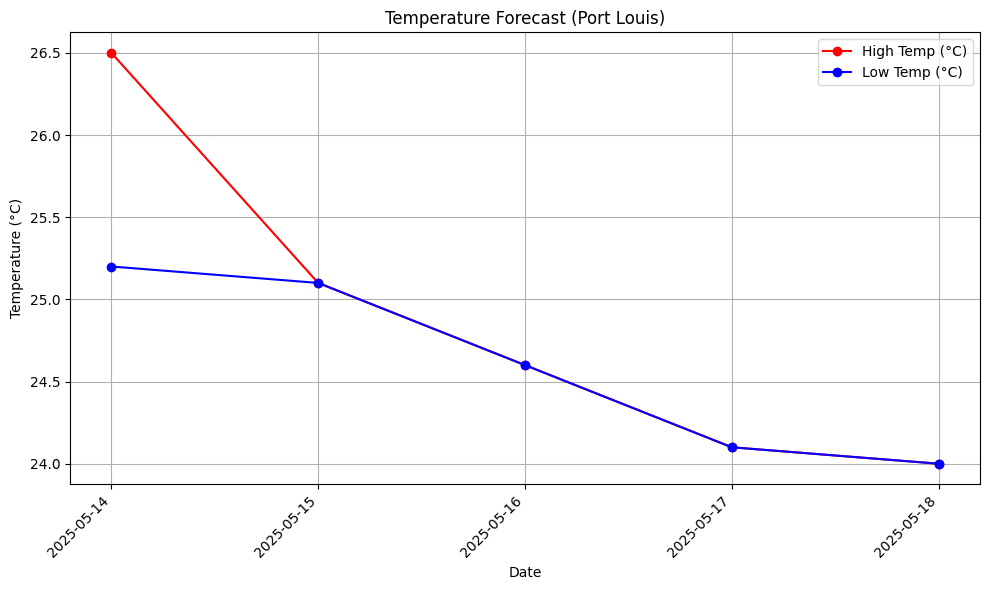

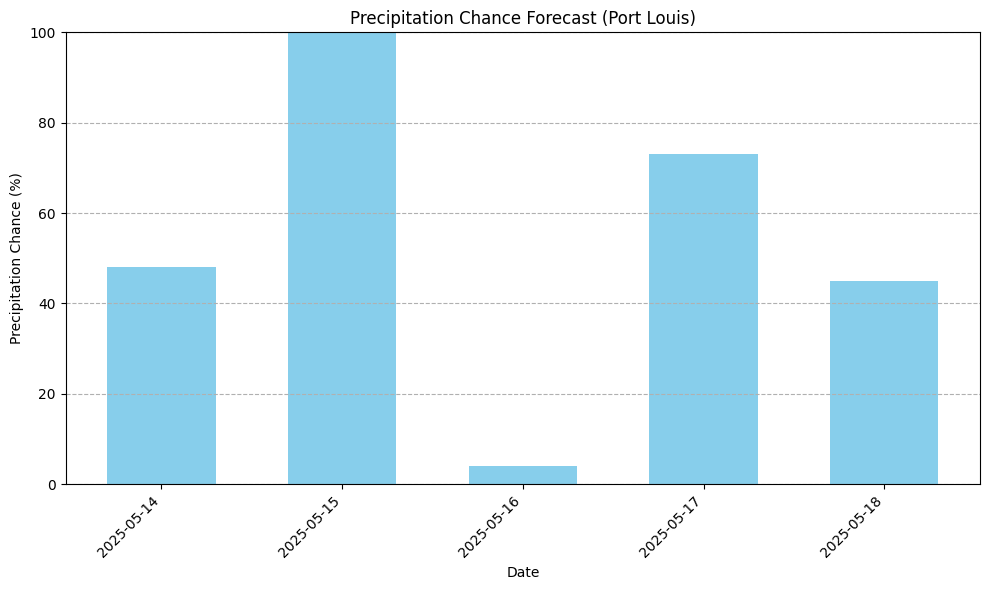

In [30]:
# Tie everything together here
!pip install pyinputplus
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
os.environ['OPENWEATHER_API_KEY'] = input("Enter your OpenWeatherMap API key: ")
# Ensure all necessary packages are imported at the beginning of your notebook
# (Assuming the setup and imports cell has already been run)
# import os
# import requests
# import matplotlib.pyplot as plt
# import pyinputplus as pyip

# Define get_weather_data() function here
def get_weather_data(forecast_days=5):
    """
    Retrieves current and forecast weather data for Port Louis, Mauritius using OpenWeatherMap API.

    Parameters:
        forecast_days (int): Number of forecast days to retrieve (maximum 5).
                             OpenWeatherMap free tier provides 5 days of forecast data
                             in 3-hour intervals.

    Returns:
        dict: {
            'current': {'summary': str},
            'forecast': [
                {
                    'date': str,
                    'high': float,
                    'low': float,
                    'precipChance': int,
                    'summary': str
                },
                ...
            ]
        }
        or a dict with an 'error' key if something went wrong.
    """
    try:
        # 📍 Fixed location
        location = "Port Louis, Mauritius"

        # 🔐 Get API key from environment
        api_key = os.environ.get("OPENWEATHER_API_KEY")
        if not api_key:
            # Using pyip.inputStr to get API key for better handling if not set
            # Note: This will prompt every time the function is called if the key is not set.
            # A better approach might be to set it once at the start of the notebook.
             api_key = pyip.inputStr("Enter your OpenWeatherMap API key: ")
             os.environ['OPENWEATHER_API_KEY'] = api_key # Optionally set it for future calls

        # Basic validation for API key format (optional but good practice)
        if not isinstance(api_key, str) or len(api_key) == 0:
             raise ValueError("Invalid API key provided.")


        # 🌐 Prepare API request
        # Using the forecast endpoint which provides 5 days of 3-hour data
        url = (
            f"https://api.openweathermap.org/data/2.5/forecast"
            f"?q={location}&appid={api_key}&units=metric"
        )

        response = requests.get(url)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        if not data or not data.get("list"):
             return {"error": "❌ API returned no data or invalid format."}

        # 📊 Build forecast list - extracting one entry per day (the first one)
        forecast_data = []
        seen_dates = set()

        # The forecast data is in 3-hour intervals. We'll take the first entry
        # for each new day encountered up to the desired number of forecast_days.
        for entry in data.get("list", []):
            # Extract date string (YYYY-MM-DD)
            dt_txt = entry.get("dt_txt")
            if not dt_txt:
                continue # Skip entries without a datetime

            date = dt_txt.split(" ")[0]

            # Process this entry if it's a new day and we haven't reached forecast_days
            if date not in seen_dates and len(forecast_data) < forecast_days:
                seen_dates.add(date)

                # Extract required information, providing default values in case keys are missing
                temp_main = entry.get("main", {})
                weather_info = entry.get("weather", [{}])[0] # weather is a list, take the first element

                forecast_entry = {
                    "date": date,
                    # Note: temp_max and temp_min from the forecast endpoint at
                    # the 3-hour interval might not be the true daily max/min.
                    # This extracts the temp_max/min from the *first* entry of the day.
                    "high": round(temp_main.get("temp_max", 0.0), 1),
                    "low": round(temp_main.get("temp_min", 0.0), 1),
                    # 'pop' is probability of precipitation
                    "precipChance": round(entry.get("pop", 0.0) * 100),
                    "summary": weather_info.get("description", "N/A").capitalize()
                }
                forecast_data.append(forecast_entry)

            # Stop if we've collected enough days
            if len(forecast_data) >= forecast_days:
                break

        # 🌥️ Current condition - Use the weather description from the very first entry
        # as a proxy for the current condition.
        current = {
            "summary": data["list"][0].get("weather", [{}])[0].get("description", "N/A").capitalize()
        }

        return {
            "current": current,
            "forecast": forecast_data
        }

    except requests.exceptions.RequestException as e:
        # Catch specific requests exceptions for network/API call issues
        return {"error": f"❌ Network or API request error: {e}"}
    except ValueError as e:
         # Catch value errors, like missing API key
         return {"error": f"❌ Configuration error: {e}"}
    except KeyError as e:
        # Catch errors if expected keys are missing in the JSON response
        return {"error": f"❌ Data format error: Missing key {e}"}
    except Exception as e:
        # Catch any other unexpected errors
        return {"error": f"❌ An unexpected error occurred: {e}"}


# --- Code to call the function and display results ---

# Ensure the API key is set before calling the function
# You can set it once at the beginning of your notebook execution
# using the input method as before, or load it from a config file.
# Example:
# if 'OPENWEATHER_API_KEY' not in os.environ:
#     os.environ['OPENWEATHER_API_KEY'] = pyip.inputStr("Enter your OpenWeatherMap API key: ")

# Call the function
weather_data = get_weather_data(forecast_days=5) # Specify the number of forecast days

# Display the results
if "error" in weather_data:
    print(weather_data["error"])
else:
    print("📍 Current Weather in Port Louis:", weather_data.get("current", {}).get("summary", "N/A"))
    print(f"📅 {len(weather_data.get('forecast', []))}-Day Forecast:") # Print actual number of forecast days retrieved
    if weather_data.get("forecast"):
        for day in weather_data["forecast"]:
            print(f"  {day.get('date', 'N/A')} — 🌡️ {day.get('low', 'N/A')}°C to {day.get('high', 'N/A')}°C | ☔ {day.get('precipChance', 'N/A')}% | {day.get('summary', 'N/A')}")
    else:
        print("  No forecast data available.")

        import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import datetime # Needed for date handling in visualisations
import matplotlib.dates # Needed for date formatting on plot axis

# --- Setup and Configuration ---

# Get API key from environment, or prompt user if not set
api_key = os.environ.get("OPENWEATHER_API_KEY")
if not api_key:
    print("OpenWeatherMap API key not found in environment variables.")
    try:
        api_key = pyip.inputStr("Please enter your OpenWeatherMap API key: ")
        os.environ['OPENWEATHER_API_KEY'] = api_key # Set for this session
    except Exception as e:
        print(f"Failed to get API key input: {e}")
        api_key = None # Ensure api_key is None if input fails


# --- Weather Data Function ---

def get_weather_data(forecast_days=5):
    """
    Retrieves current and forecast weather data for Port Louis, Mauritius using OpenWeatherMap API.

    Parameters:
        forecast_days (int): Number of forecast days to retrieve (maximum 5 for free tier).

    Returns:
        dict: {
            'current': {'summary': str},
            'forecast': [
                {
                    'date': str,
                    'high': float,
                    'low': float,
                    'precipChance': int,
                    'summary': str
                },
                ...
            ]
        }
        or a dict with an 'error' key if something went wrong.
    """
    # Get API key from environment (set previously or via input)
    api_key = os.environ.get("OPENWEATHER_API_KEY")

    if not api_key:
        return {"error": "❌ Configuration error: OpenWeatherMap API key is not set."}

    try:
        # 📍 Fixed location
        location = "Port Louis, Mauritius"

        # 🌐 Prepare API request
        # Using the forecast endpoint which provides 5 days of 3-hour data
        url = (
            f"https://api.openweathermap.org/data/2.5/forecast"
            f"?q={location}&appid={api_key}&units=metric"
        )

        response = requests.get(url)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        if not data or not data.get("list"):
             return {"error": "❌ API returned no data or invalid format."}

        # 📊 Build forecast list - extracting one entry per day (the first one)
        forecast_data = []
        seen_dates = set()

        # The forecast data is in 3-hour intervals. We'll take the first entry
        # for each new day encountered up to the desired number of forecast_days.
        for entry in data.get("list", []):
            # Extract date string (YYYY-MM-DD)
            dt_txt = entry.get("dt_txt")
            if not dt_txt:
                continue # Skip entries without a datetime

            date = dt_txt.split(" ")[0]

            # Process this entry if it's a new day and we haven't reached forecast_days
            if date not in seen_dates and len(forecast_data) < forecast_days:
                seen_dates.add(date)

                # Extract required information, providing default values in case keys are missing
                temp_main = entry.get("main", {})
                weather_info = entry.get("weather", [{}])[0] # weather is a list, take the first element

                forecast_entry = {
                    "date": date,
                    # Note: temp_max and temp_min from the forecast endpoint at
                    # the 3-hour interval might not be the true daily max/min.
                    # This extracts the temp_max/min from the *first* entry of the day.
                    "high": round(temp_main.get("temp_max", 0.0), 1),
                    "low": round(temp_main.get("temp_min", 0.0), 1),
                    # 'pop' is probability of precipitation
                    "precipChance": round(entry.get("pop", 0.0) * 100),
                    "summary": weather_info.get("description", "N/A").capitalize()
                }
                forecast_data.append(forecast_entry)

            # Stop if we've collected enough days
            if len(forecast_data) >= forecast_days:
                break

        # 🌥️ Current condition - Use the weather description from the very first entry
        # as a proxy for the current condition.
        # Use .get() for safety
        current_summary = data.get("list", [{}])[0].get("weather", [{}])[0].get("description", "N/A").capitalize()
        current = {"summary": current_summary}


        return {
            "current": current,
            "forecast": forecast_data
        }

    except requests.exceptions.RequestException as e:
        # Catch specific requests exceptions for network/API call issues
        return {"error": f"❌ Network or API request error: {e}"}
    except ValueError as e:
         # Catch value errors, like issues with data processing
         return {"error": f"❌ Data processing error: {e}"}
    except KeyError as e:
        # Catch errors if expected keys are missing in the JSON response
        return {"error": f"❌ Data format error: Missing key {e}"}
    except Exception as e:
        # Catch any other unexpected errors
        return {"error": f"❌ An unexpected error occurred: {e}"}


# --- Visualisation Functions ---

def create_temperature_visualisation(weather_data):
    """
    Creates and displays a temperature forecast visualisation (High and Low).

    Parameters:
        weather_data (dict): The dictionary returned by get_weather_data().
                             Expected format: {'forecast': [{'date': str, 'high': float, 'low': float, ...}, ...]}

    Returns:
        None. Displays a matplotlib plot.
    """
    if "error" in weather_data or not weather_data.get("forecast"):
        print("Cannot create temperature visualisation: No valid forecast data.")
        return

    forecast = weather_data["forecast"]

    # Extract data for plotting, ensuring defaults
    dates = [day.get("date", "N/A") for day in forecast]
    highs = [day.get("high", 0.0) for day in forecast]
    lows = [day.get("low", 0.0) for day in forecast]

    # Convert date strings to datetime objects for better plotting on the x-axis
    plot_dates = []
    plot_highs = []
    plot_lows = []
    for i, d in enumerate(dates):
        if d != 'N/A':
            try:
                plot_dates.append(datetime.datetime.strptime(d, "%Y-%m-%d"))
                plot_highs.append(highs[i])
                plot_lows.append(lows[i])
            except ValueError:
                print(f"Warning: Could not parse date '{d}'. Skipping entry for visualisation.")
                continue # Skip this date if parsing fails


    if not plot_dates:
        print("No valid dates found in forecast data for visualisation.")
        return

    # Create the plot
    plt.figure(figsize=(10, 6)) # Set the figure size

    # Plot high temperatures
    plt.plot(plot_dates, plot_highs, marker='o', linestyle='-', color='red', label='High Temp (°C)')

    # Plot low temperatures
    plt.plot(plot_dates, plot_lows, marker='o', linestyle='-', color='blue', label='Low Temp (°C)')

    # Add titles and labels
    plt.title("Temperature Forecast (Port Louis)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)

    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator())
    plt.xticks(rotation=45, ha='right') # Rotate dates for better readability

    plt.tight_layout() # Adjust layout to prevent labels overlapping

    # Show the plot
    plt.show()


def create_precipitation_visualisation(weather_data):
    """
    Creates and displays a precipitation chance forecast visualisation.

    Parameters:
        weather_data (dict): The dictionary returned by get_weather_data().
                             Expected format: {'forecast': [{'date': str, 'precipChance': int, ...}, ...]}

    Returns:
        None. Displays a matplotlib plot.
    """
    if "error" in weather_data or not weather_data.get("forecast"):
        print("Cannot create precipitation visualisation: No valid forecast data.")
        return

    forecast = weather_data["forecast"]

    # Extract data for plotting, ensuring defaults
    dates = [day.get("date", "N/A") for day in forecast]
    precip_chances = [day.get("precipChance", 0) for day in forecast]

    # Convert date strings to datetime objects for better plotting on the x-axis
    plot_dates = []
    plot_precip_chances = []
    for i, d in enumerate(dates):
         if d != 'N/A':
            try:
                plot_dates.append(datetime.datetime.strptime(d, "%Y-%m-%d"))
                plot_precip_chances.append(precip_chances[i])
            except ValueError:
                print(f"Warning: Could not parse date '{d}'. Skipping entry for visualisation.")
                continue # Skip this date if parsing fails


    if not plot_dates:
        print("No valid dates found in forecast data for visualisation.")
        return

    # Create the plot
    plt.figure(figsize=(10, 6)) # Set the figure size

    # Create a bar chart for precipitation chance
    # We need positions for the bars and labels
    x_positions = range(len(plot_dates))
    # Use plot_dates directly with bar for better date handling on x-axis
    plt.bar(plot_dates, plot_precip_chances, color='skyblue', width=0.6) # Add width for bar spacing

    # Add titles and labels
    plt.title("Precipitation Chance Forecast (Port Louis)")
    plt.xlabel("Date")
    plt.ylabel("Precipitation Chance (%)")
    plt.ylim(0, 100) # Precipitation chance is between 0 and 100
    plt.grid(axis='y', linestyle='--') # Add horizontal grid lines

    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator())
    plt.xticks(rotation=45, ha='right') # Rotate dates for better readability

    plt.tight_layout() # Adjust layout

    # Show the plot
    plt.show()


# --- Main Application Logic (Example Usage) ---

# Call the function to get weather data
weather_data = get_weather_data(forecast_days=5) # Specify the number of forecast days

# Display the results
if "error" in weather_data:
    print(weather_data["error"])
else:
    print("📍 Current Weather in Port Louis:", weather_data.get("current", {}).get("summary", "N/A"))
    # Safely get forecast length
    forecast_length = len(weather_data.get('forecast', []))
    print(f"📅 {forecast_length}-Day Forecast:")
    if weather_data.get("forecast"):
        for day in weather_data["forecast"]:
            print(f"  {day.get('date', 'N/A')} — 🌡️ {day.get('low', 'N/A')}°C to {day.get('high', 'N/A')}°C | ☔ {day.get('precipChance', 'N/A')}% | {day.get('summary', 'N/A')}")
    else:
        print("  No forecast data available.")

    # Create and display visualisations if data is available
    print("\nCreating visualisations...")
    create_temperature_visualisation(weather_data)
    create_precipitation_visualisation(weather_data)

## 🧪 Testing and Examples

--- Starting Tests and Examples ---

Testing get_weather_data function...
get_weather_data test successful. Retrieved data structure:
  Current keys: dict_keys(['summary'])
  Forecast days retrieved: 3
  First forecast entry keys: dict_keys(['date', 'high', 'low', 'precipChance', 'summary'])

Testing Visualisation functions...
Creating temperature visualisation example...


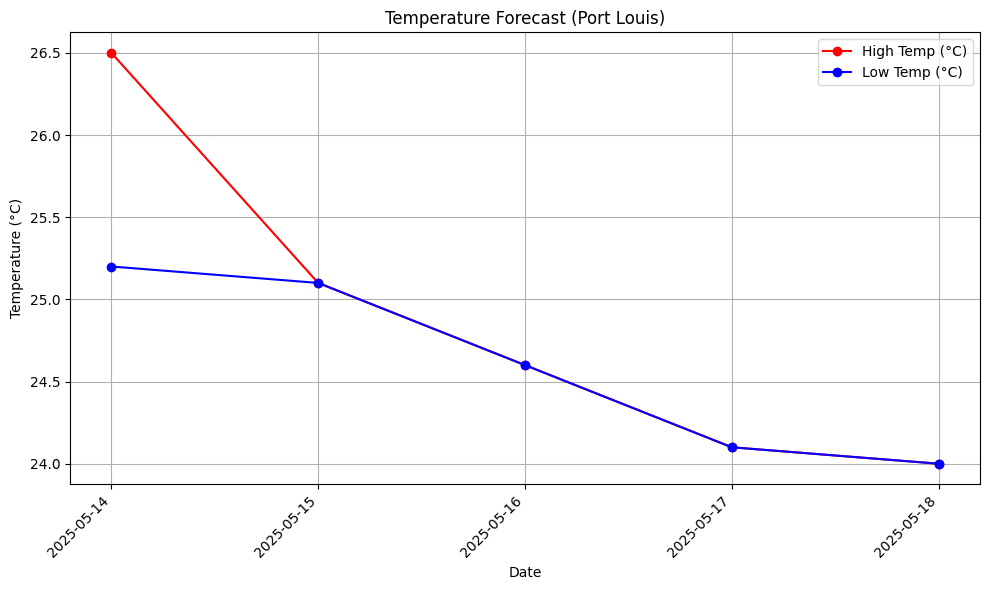

Creating precipitation visualisation example...


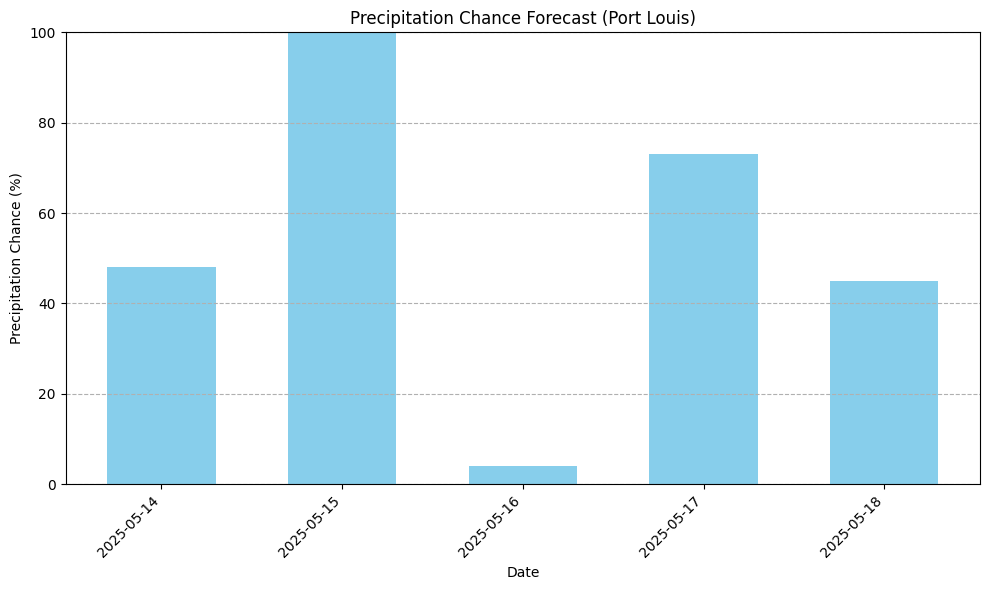


Testing NLP functions...
User input: "What's the weather like today?"
  Parsed: {'date': 'today', 'info_type': 'summary'}
  Response: Currently, the weather is Light rain. Today's forecast (2025-05-14): Light rain, with a high of 26.5°C and a low of 25.2°C. There's a 48% chance of precipitation.

User input: "Tell me the temperature tomorrow"
  Parsed: {'date': 'tomorrow', 'info_type': 'temperature'}
  Response: Tomorrow (2025-05-15), the temperature will range from 25.1°C to 25.1°C.

User input: "Is it going to rain today?"
  Parsed: {'date': 'today', 'info_type': 'precipitation'}
  Response: Currently, the weather is Light rain. Today (2025-05-14), there is a 48% chance of precipitation.

User input: "Precipitation chance tomorrow?"
  Parsed: {'date': 'tomorrow', 'info_type': 'precipitation'}
  Response: Tomorrow (2025-05-15), there is a 100% chance of precipitation.

User input: "What is the summary for today?"
  Parsed: {'date': 'today', 'info_type': 'summary'}
  Response: Current

In [32]:
# Include sample input/output for each function
# --- Testing and Examples ---

print("--- Starting Tests and Examples ---")

# --- Test get_weather_data ---
print("\nTesting get_weather_data function...")
# Call the function with a specified number of forecast days
test_weather_data = get_weather_data(forecast_days=3)

# Check the result for errors
if "error" in test_weather_data:
    print("get_weather_data test failed:", test_weather_data["error"])
else:
    print("get_weather_data test successful. Retrieved data structure:")
    # Print a summary of the retrieved data structure (don't print the whole thing if it's huge)
    print("  Current keys:", test_weather_data.get("current", {}).keys())
    print("  Forecast days retrieved:", len(test_weather_data.get("forecast", [])))
    if test_weather_data.get("forecast"):
        print("  First forecast entry keys:", test_weather_data["forecast"][0].keys())
    # You could print a small snippet if desired:
    # print("  Snippet:", test_weather_data.get("forecast", [])[:1])


# --- Test Visualisation Functions ---
print("\nTesting Visualisation functions...")
# Use the weather_data fetched previously (either test_weather_data or the main weather_data)
# Assuming weather_data from the main logic or test_weather_data from above is available
data_for_viz = weather_data if 'weather_data' in globals() and weather_data else test_weather_data

if "error" not in data_for_viz:
    print("Creating temperature visualisation example...")
    create_temperature_visualisation(data_for_viz) # Call the function
    print("Creating precipitation visualisation example...")
    create_precipitation_visualisation(data_for_viz) # Call the function
else:
    print("Skipping visualisation tests due to data error.")


# --- Test NLP Functions ---
print("\nTesting NLP functions...")

# Ensure the NLP functions are defined before testing
if 'parse_weather_question' in globals() and 'generate_weather_response' in globals():
    test_questions = [
        "What's the weather like today?",
        "Tell me the temperature tomorrow",
        "Is it going to rain today?",
        "Precipitation chance tomorrow?",
        "What is the summary for today?",
        "Tell me about the weekend weather" # Test a question the simple parser might not handle well
    ]

    # Use the weather_data fetched previously for generating responses
    data_for_nlp = weather_data if 'weather_data' in globals() and weather_data else test_weather_data

    if "error" not in data_for_nlp:
        for q in test_questions:
            print(f"User input: \"{q}\"")
            parsed_q = parse_weather_question(q)
            print(f"  Parsed: {parsed_q}")
            response = generate_weather_response(parsed_q, data_for_nlp)
            print(f"  Response: {response}\n")
    else:
         print("Skipping NLP tests due to weather data error.")

else:
    print("NLP functions (parse_weather_question, generate_weather_response) are not defined. Skipping NLP tests.")


print("--- Tests and Examples Finished ---")

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.